In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_BN_2(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, 
                      padding='same', kernel_initializer='he_uniform', 
                      input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN_2(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024000)           4096000   
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3527 - acc: 0.4236
Epoch 00001: val_loss improved from inf to 2.09511, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_3_conv_checkpoint/001-2.0951.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 2.3527 - acc: 0.4236 - val_loss: 2.0951 - val_acc: 0.4512
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0050 - acc: 0.7189
Epoch 00002: val_loss improved from 2.09511 to 1.98180, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_3_conv_checkpoint/002-1.9818.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.0051 - acc: 0.7190 - val_loss: 1.9818 - val_acc: 0.5195
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4924 - acc: 0.8590
Epoch 00003: val_loss improved from 1.98180 to 1.90014, savin

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9923
Epoch 00029: val_loss did not improve from 1.90014
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0419 - acc: 0.9923 - val_loss: 3.6019 - val_acc: 0.5460
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0596 - acc: 0.9882
Epoch 00030: val_loss did not improve from 1.90014
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0596 - acc: 0.9882 - val_loss: 3.9206 - val_acc: 0.5274
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.9901
Epoch 00031: val_loss did not improve from 1.90014
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0526 - acc: 0.9901 - val_loss: 3.9057 - val_acc: 0.5297
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0632 - acc: 0.9874
Epoch 00032: val_loss did not improve from 1.90014
36805/36805 [===========

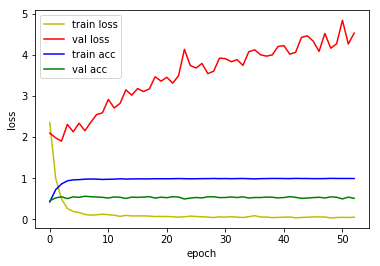

4815/4815 [==============================] - 4s 842us/sample - loss: 2.0867 - acc: 0.4993
Loss: 2.0866605542530525 Accuracy: 0.4992731

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8456 - acc: 0.4660
Epoch 00001: val_loss improved from inf to 1.43883, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_4_conv_checkpoint/001-1.4388.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.8460 - acc: 0.4660 - val_loss: 1.4388 - val_acc: 0.5628
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1081 - acc: 0.6702
Epoch 00002: val_loss improved from 1.43883 to 1.26832, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_4_conv_checkpoint/002-1.2683.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.1085 - acc: 0.6701 - val_loss: 1.2683 - val_acc: 0.6292
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9946
Epoch 00029: val_loss did not improve from 1.20309
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0324 - acc: 0.9946 - val_loss: 1.8489 - val_acc: 0.6592
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9955
Epoch 00030: val_loss did not improve from 1.20309
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0300 - acc: 0.9955 - val_loss: 1.8827 - val_acc: 0.6578
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9944
Epoch 00031: val_loss did not improve from 1.20309
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0300 - acc: 0.9944 - val_loss: 1.8472 - val_acc: 0.6625
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9953
Epoch 00032: val_loss did not improve from 1.20309
36805/36805 [===========

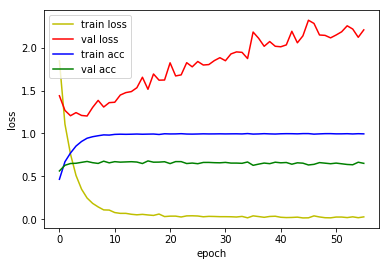

4815/4815 [==============================] - 4s 837us/sample - loss: 1.3407 - acc: 0.6345
Loss: 1.3407388262040643 Accuracy: 0.6344756

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7238 - acc: 0.4851
Epoch 00001: val_loss improved from inf to 1.24444, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_5_conv_checkpoint/001-1.2444.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 1.7237 - acc: 0.4851 - val_loss: 1.2444 - val_acc: 0.6205
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0667 - acc: 0.6795
Epoch 00002: val_loss improved from 1.24444 to 1.05356, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_5_conv_checkpoint/002-1.0536.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.0668 - acc: 0.6794 - val_loss: 1.0536 - val_acc: 0.7009
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9967
Epoch 00028: val_loss did not improve from 0.94912
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0284 - acc: 0.9967 - val_loss: 1.3087 - val_acc: 0.7375
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9958
Epoch 00029: val_loss did not improve from 0.94912
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0326 - acc: 0.9958 - val_loss: 1.3411 - val_acc: 0.7349
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0330 - acc: 0.9954
Epoch 00030: val_loss did not improve from 0.94912
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0330 - acc: 0.9954 - val_loss: 1.3270 - val_acc: 0.7368
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9960
Epoch 00031: val_loss did not improve from 0.94912
36805/36805 [===========


1D_CNN_custom_he-uniform_BN_5_conv Model


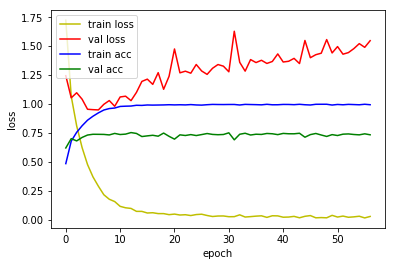

4815/4815 [==============================] - 4s 892us/sample - loss: 1.0560 - acc: 0.7101
Loss: 1.0560005102078367 Accuracy: 0.7100727

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7292 - acc: 0.4726
Epoch 00001: val_loss improved from inf to 1.23245, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_6_conv_checkpoint/001-1.2324.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 1.7293 - acc: 0.4726 - val_loss: 1.2324 - val_acc: 0.6124
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0728 - acc: 0.6757
Epoch 00002: val_loss improved from 1.23245 to 0.94370, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_6_conv_checkpoint/002-0.9437.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.0728 - acc: 0.6758 - val_loss: 0.9437 - val_acc: 0.7219
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0549 - acc: 0.9899
Epoch 00028: val_loss did not improve from 0.58371
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0550 - acc: 0.9899 - val_loss: 0.6500 - val_acc: 0.8397
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0569 - acc: 0.9897
Epoch 00029: val_loss did not improve from 0.58371
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0569 - acc: 0.9897 - val_loss: 0.7321 - val_acc: 0.8253
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9933
Epoch 00030: val_loss did not improve from 0.58371
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0446 - acc: 0.9933 - val_loss: 0.6847 - val_acc: 0.8444
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0648 - acc: 0.9857
Epoch 00031: val_loss did not improve from 0.58371
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9932
Epoch 00058: val_loss did not improve from 0.58371
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0334 - acc: 0.9931 - val_loss: 0.7040 - val_acc: 0.8551
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9935
Epoch 00059: val_loss did not improve from 0.58371
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0293 - acc: 0.9935 - val_loss: 0.7058 - val_acc: 0.8567
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9964
Epoch 00060: val_loss did not improve from 0.58371
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0217 - acc: 0.9964 - val_loss: 0.7149 - val_acc: 0.8516
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9941
Epoch 00061: val_loss did not improve from 0.58371
36805/36805 [===========

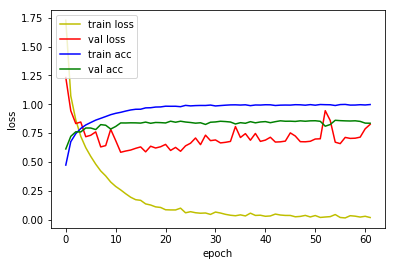

4815/4815 [==============================] - 4s 933us/sample - loss: 0.6609 - acc: 0.8102
Loss: 0.6608560858733433 Accuracy: 0.81017655

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8204 - acc: 0.4466
Epoch 00001: val_loss improved from inf to 1.26609, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_7_conv_checkpoint/001-1.2661.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 1.8203 - acc: 0.4467 - val_loss: 1.2661 - val_acc: 0.6087
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0293 - acc: 0.6973
Epoch 00002: val_loss improved from 1.26609 to 0.90620, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_7_conv_checkpoint/002-0.9062.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.0293 - acc: 0.6972 - val_loss: 0.9062 - val_acc: 0.7414
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0648 - acc: 0.9861
Epoch 00025: val_loss did not improve from 0.29053
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0649 - acc: 0.9861 - val_loss: 0.3020 - val_acc: 0.9187
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0706 - acc: 0.9831
Epoch 00026: val_loss improved from 0.29053 to 0.28061, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_7_conv_checkpoint/026-0.2806.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0707 - acc: 0.9830 - val_loss: 0.2806 - val_acc: 0.9231
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0582 - acc: 0.9869
Epoch 00027: val_loss did not improve from 0.28061
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0582 - acc: 0.9869 - val_loss: 0.2830 - val_acc: 0.9278
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0472 - 

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9969
Epoch 00055: val_loss did not improve from 0.28061
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0180 - acc: 0.9969 - val_loss: 0.3145 - val_acc: 0.9229
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9947
Epoch 00056: val_loss did not improve from 0.28061
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0256 - acc: 0.9946 - val_loss: 0.2985 - val_acc: 0.9252
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9914
Epoch 00057: val_loss did not improve from 0.28061
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0339 - acc: 0.9914 - val_loss: 0.2907 - val_acc: 0.9322
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0139 - acc: 0.9980
Epoch 00058: val_loss did not improve from 0.28061
36805/36805 [===========

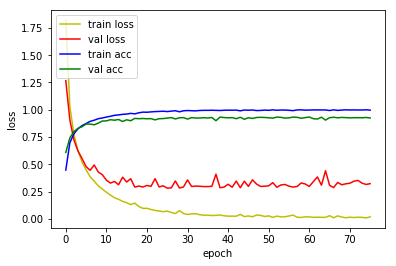

4815/4815 [==============================] - 5s 998us/sample - loss: 0.3381 - acc: 0.9024
Loss: 0.3380721197135723 Accuracy: 0.9023884

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6414 - acc: 0.5047
Epoch 00001: val_loss improved from inf to 1.06375, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_8_conv_checkpoint/001-1.0638.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 1.6413 - acc: 0.5047 - val_loss: 1.0638 - val_acc: 0.6751
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8026 - acc: 0.7702
Epoch 00002: val_loss improved from 1.06375 to 0.65917, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_8_conv_checkpoint/002-0.6592.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.8026 - acc: 0.7702 - val_loss: 0.6592 - val_acc: 0.8146
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9946
Epoch 00025: val_loss did not improve from 0.18347
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0286 - acc: 0.9946 - val_loss: 0.2113 - val_acc: 0.9394
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9914
Epoch 00026: val_loss did not improve from 0.18347
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0390 - acc: 0.9914 - val_loss: 0.1897 - val_acc: 0.9460
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0239 - acc: 0.9960
Epoch 00027: val_loss did not improve from 0.18347
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0239 - acc: 0.9960 - val_loss: 0.2017 - val_acc: 0.9446
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9951
Epoch 00028: val_loss did not improve from 0.18347
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9995
Epoch 00054: val_loss did not improve from 0.17689
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0049 - acc: 0.9995 - val_loss: 0.2029 - val_acc: 0.9525
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.9991
Epoch 00055: val_loss did not improve from 0.17689
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0061 - acc: 0.9990 - val_loss: 0.2337 - val_acc: 0.9427
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9921
Epoch 00056: val_loss did not improve from 0.17689
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0262 - acc: 0.9920 - val_loss: 0.2577 - val_acc: 0.9362
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9923
Epoch 00057: val_loss did not improve from 0.17689
36805/36805 [========================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9992
Epoch 00084: val_loss did not improve from 0.17689
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0048 - acc: 0.9992 - val_loss: 0.2079 - val_acc: 0.9557

1D_CNN_custom_he-uniform_BN_8_conv Model


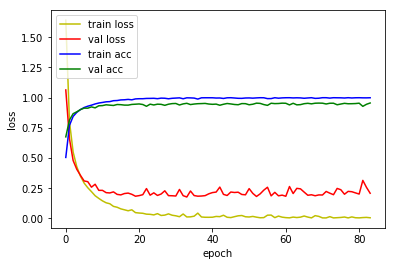

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2418 - acc: 0.9379
Loss: 0.24182108643765515 Accuracy: 0.9379024

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3090 - acc: 0.5948
Epoch 00001: val_loss improved from inf to 0.74516, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_9_conv_checkpoint/001-0.7452.hdf5
36805/36805 [==============================] - 115s 3ms/sample - loss: 1.3090 - acc: 0.5948 - val_loss: 0.7452 - val_acc: 0.7780
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5491 - acc: 0.8332
Epoch 00002: val_loss improved from 0.74516 to 0.42370, saving model to model/checkpoint/1D_CNN_custom_he-uniform_BN_9_conv_checkpoint/002-0.4237.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.5491 - acc: 0.8332 - val_loss: 0.4237 - val_acc: 0.8719
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9988
Epoch 00027: val_loss did not improve from 0.16054
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0092 - acc: 0.9988 - val_loss: 0.1895 - val_acc: 0.9520
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9977
Epoch 00028: val_loss did not improve from 0.16054
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0122 - acc: 0.9977 - val_loss: 0.2231 - val_acc: 0.9418
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9946
Epoch 00029: val_loss did not improve from 0.16054
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0199 - acc: 0.9946 - val_loss: 0.1681 - val_acc: 0.9564
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0170 - acc: 0.9960
Epoch 00030: val_loss did not improve from 0.16054
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9972
Epoch 00057: val_loss did not improve from 0.16054
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0100 - acc: 0.9972 - val_loss: 0.1898 - val_acc: 0.9553
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0054 - acc: 0.9991
Epoch 00058: val_loss did not improve from 0.16054
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0054 - acc: 0.9991 - val_loss: 0.2192 - val_acc: 0.9525
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9995
Epoch 00059: val_loss did not improve from 0.16054
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0039 - acc: 0.9995 - val_loss: 0.1700 - val_acc: 0.9602
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9953
Epoch 00060: val_loss did not improve from 0.16054
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.9990
Epoch 00086: val_loss did not improve from 0.15754
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0046 - acc: 0.9990 - val_loss: 0.1767 - val_acc: 0.9639
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.9991
Epoch 00087: val_loss did not improve from 0.15754
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0035 - acc: 0.9990 - val_loss: 0.2357 - val_acc: 0.9488
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9964
Epoch 00088: val_loss did not improve from 0.15754
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0118 - acc: 0.9964 - val_loss: 0.1676 - val_acc: 0.9627
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.9996
Epoch 00089: val_loss did not improve from 0.15754
36805/36805 [========================

Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9997
Epoch 00116: val_loss did not improve from 0.15754
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0017 - acc: 0.9997 - val_loss: 0.1714 - val_acc: 0.9641
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 8.2192e-04 - acc: 0.9999
Epoch 00117: val_loss did not improve from 0.15754
36805/36805 [==============================] - 93s 3ms/sample - loss: 8.2182e-04 - acc: 0.9999 - val_loss: 0.1671 - val_acc: 0.9648
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.2278e-04 - acc: 0.9999
Epoch 00118: val_loss did not improve from 0.15754
36805/36805 [==============================] - 93s 3ms/sample - loss: 6.2270e-04 - acc: 0.9999 - val_loss: 0.1755 - val_acc: 0.9641

1D_CNN_custom_he-uniform_BN_9_conv Model


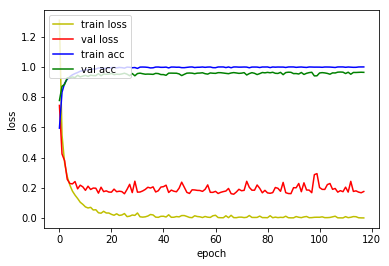

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2236 - acc: 0.9495
Loss: 0.22355228183812317 Accuracy: 0.9495327



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_he-uniform_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN_2(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_he-uniform_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_he-uniform_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.0560 - acc: 0.7101
Loss: 1.0560005102078367 Accuracy: 0.7100727

1D_CNN_custom_he-uniform_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_57 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_70 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_58 (Activation)   (Non

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3381 - acc: 0.9024
Loss: 0.3380721197135723 Accuracy: 0.9023884

1D_CNN_custom_he-uniform_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_84 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_70 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_85 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_71 (Activation)   (Non

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2236 - acc: 0.9495
Loss: 0.22355228183812317 Accuracy: 0.9495327


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_BN_2'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_he-uniform_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.8046 - acc: 0.6872
Loss: 1.8046407324007614 Accuracy: 0.6872274

1D_CNN_custom_he-uniform_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_57 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_70 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_58 (Activation)   (Non

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3690 - acc: 0.9126
Loss: 0.36902239811011933 Accuracy: 0.9125649

1D_CNN_custom_he-uniform_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_84 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_70 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_85 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_71 (Activation)   (No

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2154 - acc: 0.9524
Loss: 0.21542760161054345 Accuracy: 0.95244026
